<a href="https://colab.research.google.com/github/Kwanikaze/vpandas/blob/master/VAE_OHE_8digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

## Generate Data

In [2]:
def generate_data(num=8):
    """ Generate 'num' number of one-hot encoded integers. """ 
    x_train = np.eye(num)[np.arange(num)]                       # This is a simple way to one-hot encode integers
    
    # Repeat x_train multiple times for training
    x_train = np.repeat(x_train, 100, axis=0)
    
    # The target is x_train itself!
    x_target = x_train.copy()
    return x_train, x_target

In [3]:
num = 8
np.random.seed(10)
x_train, x_target = generate_data(num=num)

In [4]:
print(x_train)
print(np.shape(x_train))
print(np.shape(x_target))

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
(800, 8)
(800, 8)


## Variational Autoencoder Parameters

In [5]:
#Parameters
latent_dims = 3
num_epochs = 2000
batch_size = 64
learning_rate = 1e-3
use_gpu = True
variational_beta = 0.00001 #tuned

## VAE Definition
https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=0psoODlF9S_Y

https://stats.stackexchange.com/questions/361643/sampling-z-in-vae

https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.latent_dims = latent_dims
        self.fc1 = nn.Linear(num, latent_dims) # why have this additional fc layer?
        self.fc_mu = nn.Linear(latent_dims, latent_dims)
        self.fc_logvar = nn.Linear(latent_dims, latent_dims)
        #self.fc_mu = nn.Linear(num, latent_dims)
        #self.fc_logvar = nn.Linear(num, latent_dims)
        self.fc_out = nn.Linear(latent_dims,num)

    def encode(self, x):
        h1 = torch.sigmoid(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)
        #return torch.sigmoid(self.fc_mu(x)),torch.sigmoid(self.fc_logvar(x))

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        if z.size()[0] == self.latent_dims: #resize from [3] to [1,3]
          z = z.view(1, self.latent_dims)
        softmax = nn.Softmax(dim=1)
        recon = softmax(self.fc_out(z))
        return recon

    def forward(self, x, latent_dims):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def latent(self,x,latent_dims):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z

    def sample(self, num_samples):
      # ignore latent_mu, latent_logvar, instead generate z values from standard normal
      z = torch.randn(num_samples, self.latent_dims)
      z = z.to(device)
      samples = self.decode(z)
      return samples

def vae_loss(batch_recon, x_batch_targets, mu, logvar):
  criterion = nn.CrossEntropyLoss()
  CE = criterion(batch_recon, x_batch_targets)
  #print(CE)
  #BCE = F.binary_cross_entropy(recon, x, reduction='sum') #one hot encoded input
  KLd = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes
  #print(KLd)
  return CE,variational_beta*KLd, CE + variational_beta*KLd

In [7]:
def trainVAE(VAE, latent_dims):
  VAE.train()
  x_train, x_target = generate_data(num=num)
  inds = list(range(x_train.shape[0]))
  N = x_train.shape[0] # 800
  freq = num_epochs // 10 # floor division

  loss_hist = []
  x_train = Variable(torch.from_numpy(x_train))
  x_target = Variable(torch.from_numpy(x_target))
  for epoch in range(num_epochs):
      inds = np.random.permutation(inds)
      x_train = x_train[inds]
      x_train = x_train.to(device)
      x_target = x_target[inds]
      x_target = x_target.to(device)
      
      loss = 0
      CE = 0
      KLd = 0
      num_batches = N / batch_size
      for b in range(0, N, batch_size):
          #get the mini-batch
          x_batch = x_train[b: b+batch_size]
          x_target_batch = x_target[b: b+batch_size]
          
          #feed forward
          batch_recon,latent_mu,latent_logvar = VAE(x=x_batch.float(),latent_dims = latent_dims)
          
          # Error
          #Convert x_batch from OHE vectors to single scalar for target class, of each sample in batch 
          _, x_batch_targets = x_batch.max(dim=1)
          train_CE, train_KLd, train_loss = vae_loss(batch_recon, x_batch_targets, latent_mu, latent_logvar)
          #print(batch_recon.size())
          #print(x_batch_targets.size())
          loss += train_loss.item() / N # update epoch loss
          CE += train_CE.item() / N 
          KLd += train_KLd.item() / N 

          #Backprop the error, compute the gradient
          optimizer.zero_grad()
          train_loss.backward()
          
          #update parameters based on gradient
          optimizer.step()
          
      #Record loss per epoch        
      loss_hist.append(loss)
      
      if epoch % freq == 0:
          print()
          print("Epoch %d/%d\t CE: %.5f, KLd: %.5f, Train loss=%.5f" % (epoch + 1, num_epochs,CE,KLd, loss), end='\t', flush=True)
          
          #Test with all training data
          VAE.eval()
          train_recon, train_mu, train_logvar = VAE(x = x_train.float(),latent_dims=latent_dims)
          _, x_targets = x_target.max(dim=1)
          CE,KLd,test_loss = vae_loss(train_recon, x_targets, train_mu, train_logvar)
          print("\t CE: {:.5f}, KLd: {:.5f}, Test loss: {:.5f}".format(CE,KLd,test_loss.item()), end='')
      
  print("\nTraining finished!")

## Latent dimensions set to 3

In [8]:
#  use gpu if available
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
VAE = VariationalAutoencoder(latent_dims=3)
VAE = VAE.to(device)
num_params = sum(p.numel() for p in VAE.parameters() if p.requires_grad)
print(VAE.parameters)
print("Number of parameters: %d" % num_params) #8*3 + 3 = 27, 3*8 + 8 = 32, 27+32

# optimizer object
optimizer = torch.optim.Adam(params = VAE.parameters(), lr = learning_rate)
#criterion = nn.CrossEntropyLoss()    # for target, does not accept a OHE vector
#criterion = nn.NLLLoss()

trainVAE(VAE, latent_dims=3)

<bound method Module.parameters of VariationalAutoencoder(
  (fc1): Linear(in_features=8, out_features=3, bias=True)
  (fc_mu): Linear(in_features=3, out_features=3, bias=True)
  (fc_logvar): Linear(in_features=3, out_features=3, bias=True)
  (fc_out): Linear(in_features=3, out_features=8, bias=True)
)>
Number of parameters: 83

Epoch 1/2000	 CE: 0.03384, KLd: 0.00000, Train loss=0.03384		 CE: 2.08206, KLd: 0.00260, Test loss: 2.08466
Epoch 201/2000	 CE: 0.02184, KLd: 0.00009, Train loss=0.02193		 CE: 1.34270, KLd: 0.07053, Test loss: 1.41323
Epoch 401/2000	 CE: 0.02075, KLd: 0.00011, Train loss=0.02086		 CE: 1.27714, KLd: 0.08622, Test loss: 1.36336
Epoch 601/2000	 CE: 0.02072, KLd: 0.00009, Train loss=0.02081		 CE: 1.27517, KLd: 0.06846, Test loss: 1.34362
Epoch 801/2000	 CE: 0.02071, KLd: 0.00007, Train loss=0.02078		 CE: 1.27459, KLd: 0.05445, Test loss: 1.32904
Epoch 1001/2000	 CE: 0.02071, KLd: 0.00006, Train loss=0.02077		 CE: 1.27445, KLd: 0.04844, Test loss: 1.32289
Epoch 1201

KL Divergence increases, then decreases. Cross Entropy loss (reconstruction term of the ELBO) steadily decreases.

In [9]:
print("Print prediction results:")
x_test = np.eye(num)[np.arange(num)]                        # Test data (one-hot encoded)
x_test = Variable(torch.from_numpy(x_test))
x_test = x_test.to(device)
#np.set_printoptions(2)
for x in x_test:
    print("\tInput: {} \t Output: {}".format(x.cpu().detach().numpy(), np.round(VAE(x=x.float(),latent_dims=3)[0].cpu().detach().numpy(),decimals=2)))

Print prediction results:
	Input: [1. 0. 0. 0. 0. 0. 0. 0.] 	 Output: [[1. 0. 0. 0. 0. 0. 0. 0.]]
	Input: [0. 1. 0. 0. 0. 0. 0. 0.] 	 Output: [[0. 1. 0. 0. 0. 0. 0. 0.]]
	Input: [0. 0. 1. 0. 0. 0. 0. 0.] 	 Output: [[0. 0. 1. 0. 0. 0. 0. 0.]]
	Input: [0. 0. 0. 1. 0. 0. 0. 0.] 	 Output: [[0. 0. 0. 1. 0. 0. 0. 0.]]
	Input: [0. 0. 0. 0. 1. 0. 0. 0.] 	 Output: [[0. 0. 0. 0. 1. 0. 0. 0.]]
	Input: [0. 0. 0. 0. 0. 1. 0. 0.] 	 Output: [[0. 0. 0. 0. 0. 1. 0. 0.]]
	Input: [0. 0. 0. 0. 0. 0. 1. 0.] 	 Output: [[0. 0. 0. 0. 0. 0. 1. 0.]]
	Input: [0. 0. 0. 0. 0. 0. 0. 1.] 	 Output: [[0. 0. 0. 0. 0. 0. 0. 1.]]


## Extract intermediate features using Forward Hook

In [10]:
def inside_layer(self, input1, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print('\tInside ' + self.__class__.__name__ + ' forward')
    #print('\t input:', input1[0].cpu().detach().numpy())
    print('\t input rounded to 2 decimals:', np.round(input1[0].cpu().detach().numpy(),2))
    #print('\t output:', output.cpu().detach().numpy())
    print('\t output rounded to 2 decimals:', np.round(output.cpu().detach().numpy(),2))

In [11]:
mu_hook = VAE.fc_mu.register_forward_hook(inside_layer)
for x in x_test:
    print('INPUT: {}'.format(x.cpu().detach().numpy()))
    out = VAE(x=x.float(),latent_dims=3)
    #print(out)
mu_hook.remove() #remove hook after use

INPUT: [1. 0. 0. 0. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [0.89 0.69 0.57]
	 output rounded to 2 decimals: [1.3  0.93 1.27]
INPUT: [0. 1. 0. 0. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [0.79 0.08 0.1 ]
	 output rounded to 2 decimals: [ 1.89 -0.5  -1.22]
INPUT: [0. 0. 1. 0. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [0.06 0.27 0.01]
	 output rounded to 2 decimals: [-0.49 -2.01 -1.08]
INPUT: [0. 0. 0. 1. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [0.33 0.63 0.92]
	 output rounded to 2 decimals: [-1.28  1.7   0.8 ]
INPUT: [0. 0. 0. 0. 1. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [0.58 0.79 0.07]
	 output rounded to 2 decimals: [ 1.19 -1.68  1.25]
INPUT: [0. 0. 0. 0. 0. 1. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [0.75 0.04 0.69]
	 output rounded to 2 decimals: [ 0.61  1.93 -1.19]
INPUT: [0. 0. 0. 0. 0. 0. 1. 0.]
	Inside Linear forward
	 input rou

In [12]:
decoder_hook = VAE.fc_out.register_forward_hook(inside_layer)
for x in x_test:
    print('INPUT: {}'.format(x.cpu().detach().numpy()))
    out = VAE(x=x.float(),latent_dims=3)
    #print(out)
decoder_hook.remove() #remove hook after use

INPUT: [1. 0. 0. 0. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [[1.15 1.31 1.21]]
	 output rounded to 2 decimals: [[ 16.81   0.2  -11.93   5.96   1.19   5.93  -4.66 -12.84]]
INPUT: [0. 1. 0. 0. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [[ 1.81 -0.47 -1.06]]
	 output rounded to 2 decimals: [[  0.9   16.38   4.07 -15.18   2.36   4.44 -15.64  -7.34]]
INPUT: [0. 0. 1. 0. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [[ 0.02 -1.59 -0.84]]
	 output rounded to 2 decimals: [[ -9.96   6.38  13.66 -11.95   3.37  -7.09  -0.17   1.1 ]]
INPUT: [0. 0. 0. 1. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [[-1.53  1.52  0.61]]
	 output rounded to 2 decimals: [[  1.97 -14.38  -6.09  18.62 -13.26   4.65   6.85   8.2 ]]
INPUT: [0. 0. 0. 0. 1. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [[ 1.5  -1.51  1.38]]
	 output rounded to 2 decimals: [[  9.55   6.63   3.67 -11.57  20.09 -12.52   3.66 -20.89]

## Generate Samples
https://www.jeremyjordan.me/variational-autoencoders/

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [13]:
samples = VAE.sample(num_samples=1000)
#print(samples[0:5])
print(np.round(samples[0:9].cpu().detach().numpy(),2))

[[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.03 0.   0.   0.   0.   0.97 0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.06 0.   0.94 0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.97 0.   0.03 0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.  ]]


Samples sum to 1. Most are almost OHE vectors. As the latent space becomes more continous, closer resemblance to OHE vectors? If latent space more  disjointed, than output tends to be less OHE vectors.

## Visualize Latent Space

Can view tradeoff in continuous latent space vs focussed point distributions as varying weight placed on KL Divergence.

In [14]:
x_train, x_target = generate_data(num=num)
x_train = Variable(torch.from_numpy(x_train))

np_z = np.empty(0)
for x in x_train:
  z = VAE.latent(x.float(),latent_dims)
  #print(z)
  np_z = np.concatenate((np_z, z.cpu().detach().numpy()))
np_z = np_z.reshape(800,3)
#print(np_z[:,0])

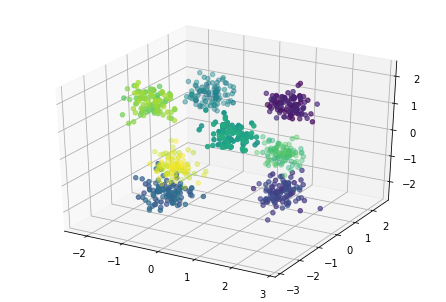

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
t = np.arange(800)
ax.scatter(np_z[:,0], np_z[:,1], np_z[:,2], c = t)

In [16]:
from sklearn.manifold import TSNE
z_embedded = TSNE(n_components=2).fit_transform(np_z)
z_embedded.shape

(800, 2)

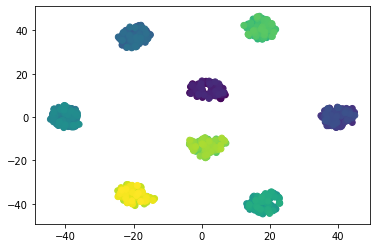

In [17]:
plt.scatter(z_embedded[:,0],z_embedded[:,1],c=t)